# **4.1 Diferencias usando distintos metodos de balanceo (SMOTE, ADASYN, etc) y RandomForest:**

Se selccionan las variables explicativas y la respuesta.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_curve, roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN


In [3]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [4]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [6]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [8]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calcular AUC si hay probabilidades
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Mostrar métricas
    print(f"Modelo: {nombre_modelo}")
    print("Accuracy:", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:", round(recall, 3))
    print("F1-score:", round(f1, 3))
    if auc is not None:
        print("AUC:", round(auc, 3))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend(loc="lower right")
        plt.show()

    # Retornar resultados en formato de diccionario
    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }

## **4.1.1 RandomForest sin tecnicas de balanceo**

In [9]:
randomforest_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=100,       # número de árboles
        max_depth=None,         # sin límite de profundidad
        min_samples_split=2,    # mínimo de muestras para dividir un nodo
        min_samples_leaf=1,     # mínimo de muestras por hoja
        random_state=42,
        n_jobs=-1               # usa todos los núcleos
    ))
])

In [10]:
randomforest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

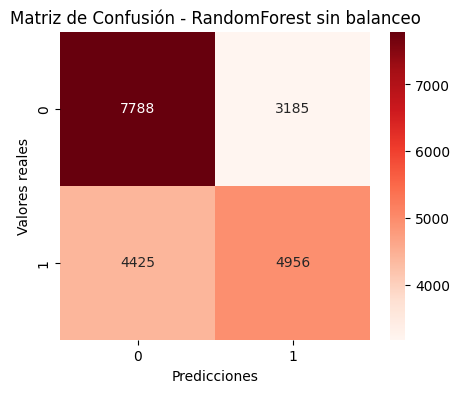

Modelo: RandomForest sin balanceo
Accuracy: 0.626
Precision: 0.609
Recall: 0.528
F1-score: 0.566
AUC: 0.675

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.64      0.71      0.67     10973
           1       0.61      0.53      0.57      9381

    accuracy                           0.63     20354
   macro avg       0.62      0.62      0.62     20354
weighted avg       0.62      0.63      0.62     20354



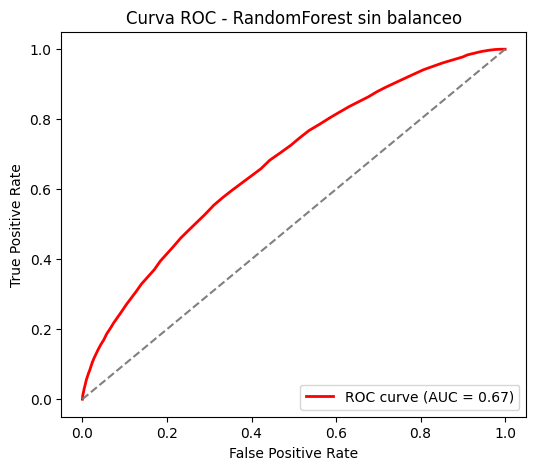

In [11]:
rf_normal = evaluar_modelo(randomforest_pipeline, X_test, y_test, nombre_modelo="RandomForest sin balanceo")

## **4.1.2 RandomForest con SMOTE**

In [18]:
rf_pipeline_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    ))
])

In [19]:
rf_pipeline_smote.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

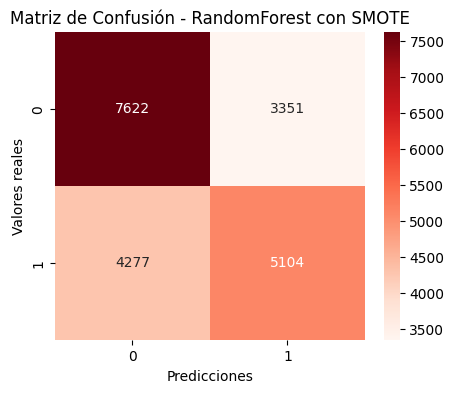

Modelo: RandomForest con SMOTE
Accuracy: 0.625
Precision: 0.604
Recall: 0.544
F1-score: 0.572
AUC: 0.676

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.64      0.69      0.67     10973
           1       0.60      0.54      0.57      9381

    accuracy                           0.63     20354
   macro avg       0.62      0.62      0.62     20354
weighted avg       0.62      0.63      0.62     20354



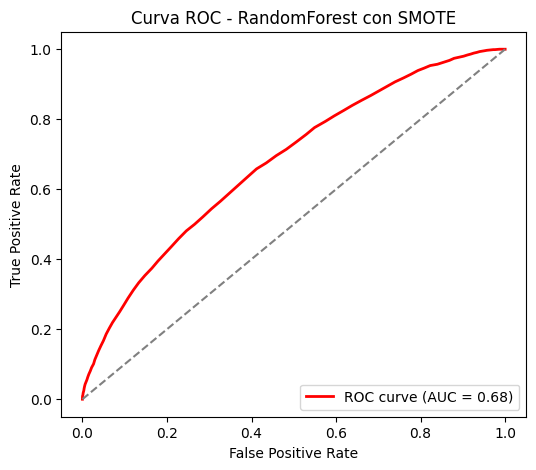

In [20]:
rf_smote = evaluar_modelo(rf_pipeline_smote, X_test, y_test, nombre_modelo="RandomForest con SMOTE")

## **4.1.3 RandomForest con ADASYN**

In [17]:

rf_pipeline_adasyn = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(random_state=42)),
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    ))
])

try:
    rf_pipeline_adasyn.fit(X_train, y_train)
    result_rf_adasyn = evaluar_modelo(rf_pipeline_adasyn, X_test, y_test, nombre_modelo="RandomForest con ADASYN")
except ValueError as e:
    print(f"ADASYN no pudo generar muestras sintéticas: {e}")
    result_rf_adasyn = {"Modelo": "RandomForest con ADASYN", "Accuracy": None, "Precision": None, "Recall": None, "F1": None, "AUC": None}

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


ADASYN no pudo generar muestras sintéticas: No samples will be generated with the provided ratio settings.


Gracias al balanceo existente en la clase objetivo, como se puede ver a continuacion, ADASYN no puede crear datos sinteticos para poder balancear, en este caso, no se tomara en cuenta.

In [45]:
y_train.value_counts(normalize=True)

readmitted
0    0.539122
1    0.460878
Name: proportion, dtype: float64

## **4.1.4 RandomForest con class_weight=’balanced’**


In [12]:
rf_pipeline_balanced = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

In [13]:
rf_pipeline_balanced.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

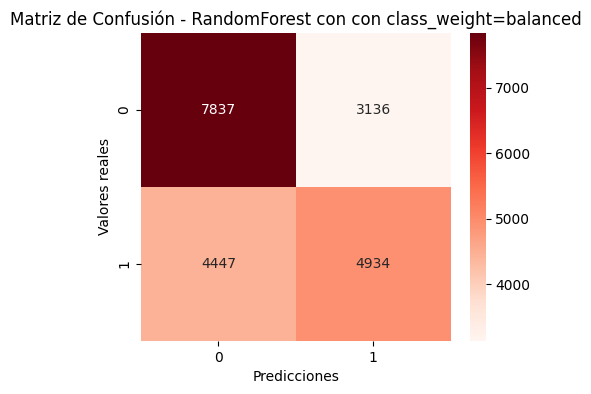

Modelo: RandomForest con con class_weight=balanced
Accuracy: 0.627
Precision: 0.611
Recall: 0.526
F1-score: 0.565
AUC: 0.676

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.64      0.71      0.67     10973
           1       0.61      0.53      0.57      9381

    accuracy                           0.63     20354
   macro avg       0.62      0.62      0.62     20354
weighted avg       0.63      0.63      0.62     20354



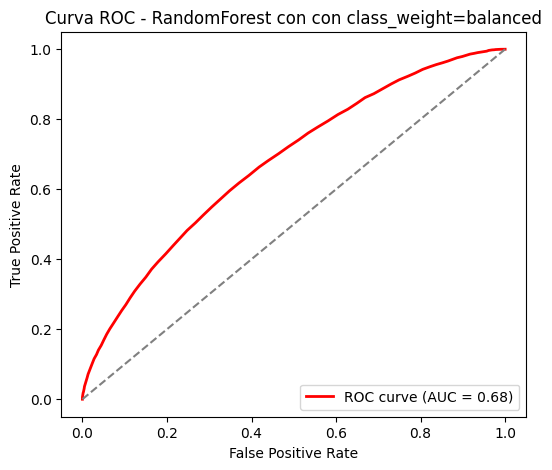

In [14]:
rf_balanced = evaluar_modelo(rf_pipeline_balanced, X_test, y_test, nombre_modelo="RandomForest con con class_weight=balanced")

## **4.1.5 Comparacion de resultados de tecnicas de balanceo para KNN**


In [21]:
tabla_resultados = pd.DataFrame([
    rf_normal,
    rf_smote,
    rf_balanced
])

In [22]:
# Ordenar por Recall descendente
df_ordenado = tabla_resultados.sort_values(by="Recall", ascending=False).reset_index(drop=True)

# Mostrar tabla ordenada
print(df_ordenado)

                                       Modelo  Accuracy  Precision    Recall  \
0                      RandomForest con SMOTE  0.625233   0.603666  0.544078   
1                   RandomForest sin balanceo  0.626118   0.608770  0.528302   
2  RandomForest con con class_weight=balanced  0.627444   0.611400  0.525957   

         F1       AUC  
0  0.572326  0.676410  
1  0.565689  0.674706  
2  0.565469  0.675891  
